In [10]:
%pip install pandas matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [11]:
import pandas as pd

df = pd.read_csv('CloudWatch_Traffic_Web_Attack.csv')

print("Data loaded successfully!")
df.head()

Data loaded successfully!


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


In [ ]:

print("Missing values in each column:\n", df.isnull().sum())

df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['time'] = pd.to_datetime(df['time'])

df['src_ip_country_code'] = df['src_ip_country_code'].str.upper()

print("Preprocessing complete!")
df.info()

Missing values in each column:
 bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64
Preprocessing complete!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   bytes_in             282 non-null    int64              
 1   bytes_out            282 non-null    int64              
 2   creation_time        282 non-null    datetime64[ns, UTC]
 3   end_time             282 non-null    datetime64[ns, UTC]
 4   src_ip               282 non-null    object      

In [ ]:

df['session_duration'] = (df['end_time'] - df['creation_time']).dt.total_seconds()


df['avg_packet_size'] = (df['bytes_in'] + df['bytes_out']) / (df['session_duration'] + 1)

print("New features 'session_duration' and 'avg_packet_size' created.")
df[['session_duration', 'avg_packet_size']].head()

New features 'session_duration' and 'avg_packet_size' created.


,session_duration,avg_packet_size
0,600.0,30.935108
1,600.0,81.693844
2,600.0,69.840266
3,600.0,74.582363
4,600.0,33.973378


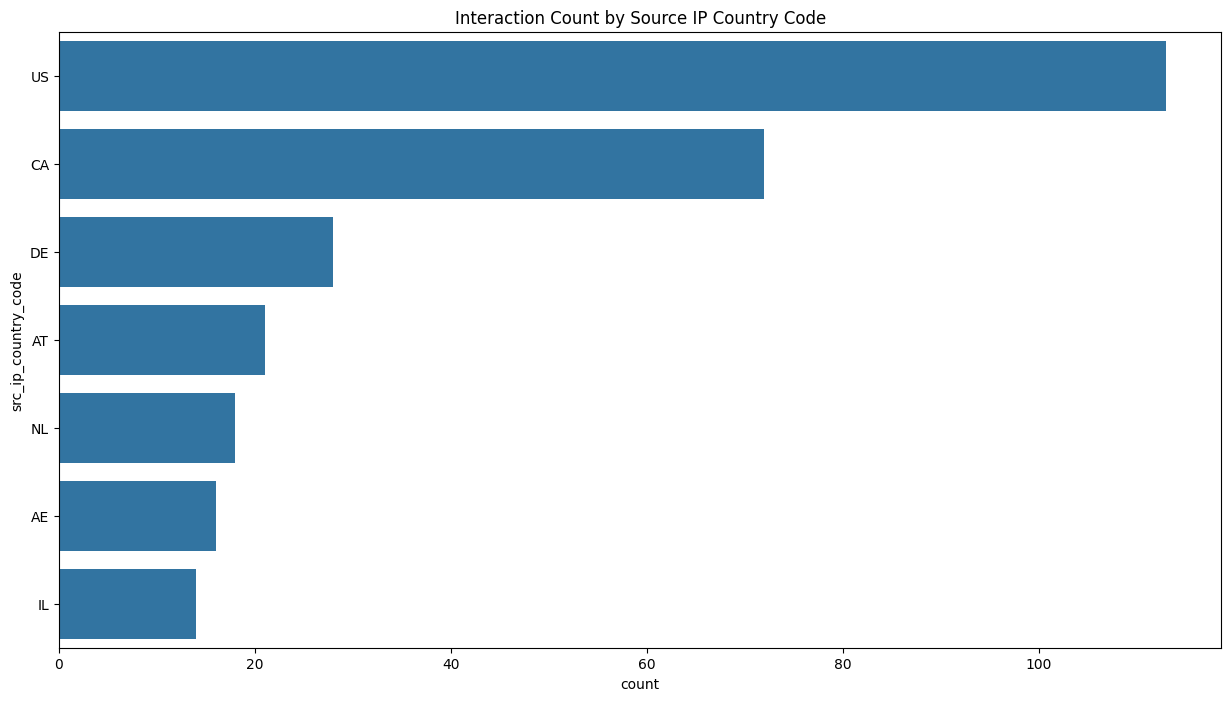

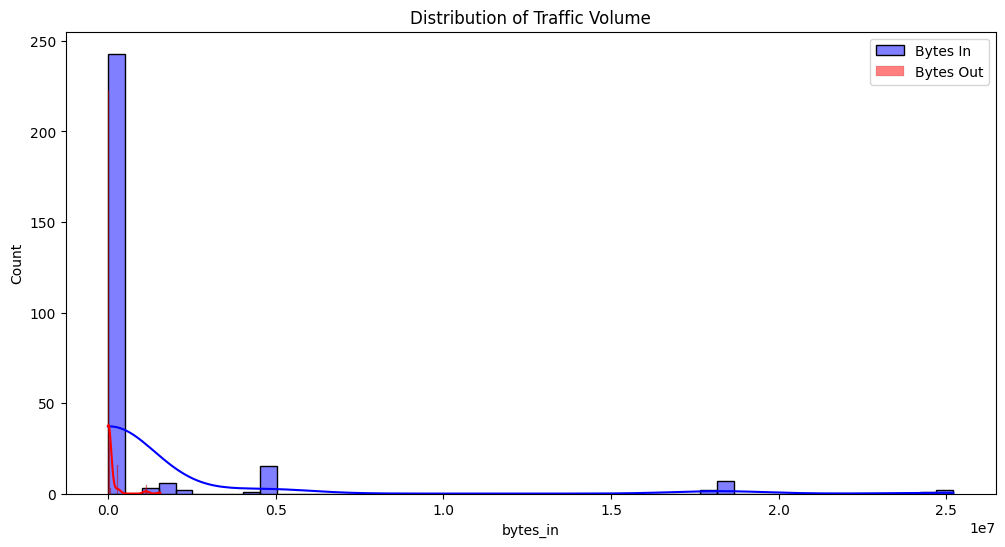

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,8))
sns.countplot(y='src_ip_country_code', data=df, 
              order=df['src_ip_country_code'].value_counts().index)
plt.title('Interaction Count by Source IP Country Code')
plt.show()


plt.figure(figsize=(12,6))
sns.histplot(df['bytes_in'], bins=50, color='blue', label='Bytes In', kde=True)
sns.histplot(df['bytes_out'], bins=50, color='red', label='Bytes Out', kde=True)
plt.legend()
plt.title('Distribution of Traffic Volume')
plt.show()

In [ ]:
from sklearn.ensemble import IsolationForest

features = df[['bytes_in', 'bytes_out', 'session_duration', 'avg_packet_size']]

model = IsolationForest(contamination=0.05, random_state=42)


df['anomaly_score'] = model.fit_predict(features)
df['anomaly'] = df['anomaly_score'].apply(lambda x: 'Suspicious' if x == -1 else 'Normal')


print(df['anomaly'].value_counts())

anomaly
Normal        267
Suspicious     15
Name: count, dtype: int64


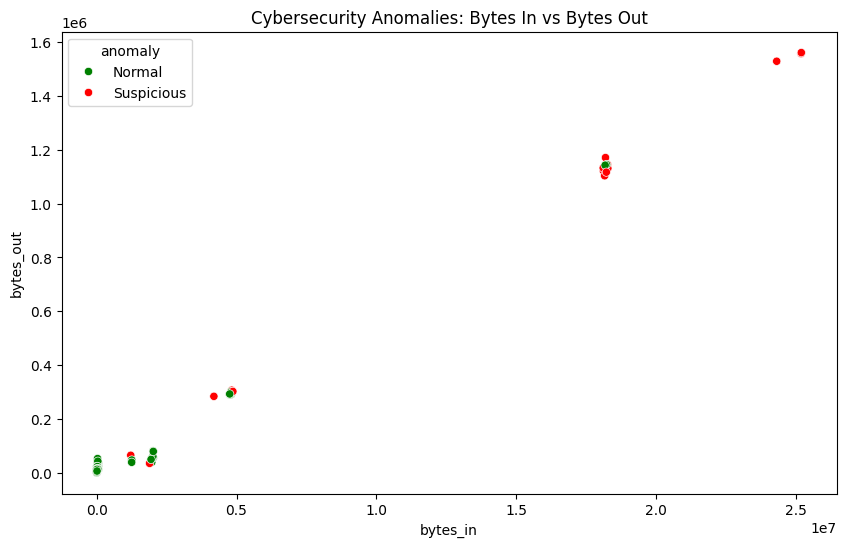

In [16]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='bytes_in', y='bytes_out', hue='anomaly', 
                data=df, palette={'Normal': 'green', 'Suspicious': 'red'})
plt.title('Cybersecurity Anomalies: Bytes In vs Bytes Out')
plt.show()

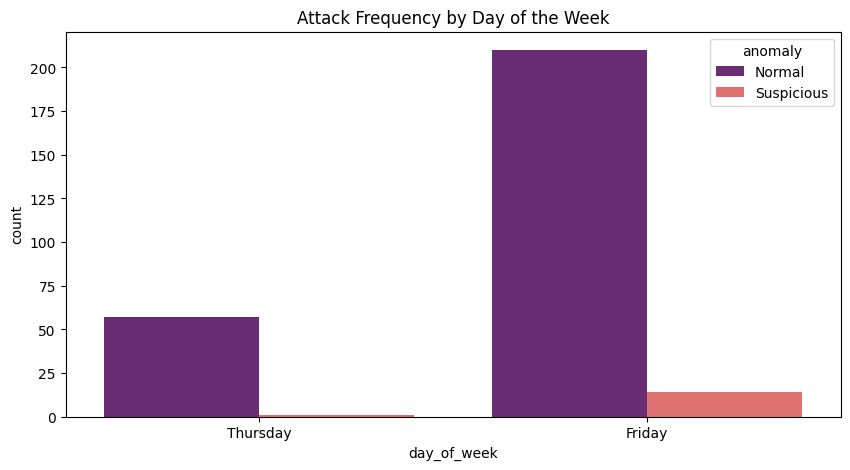

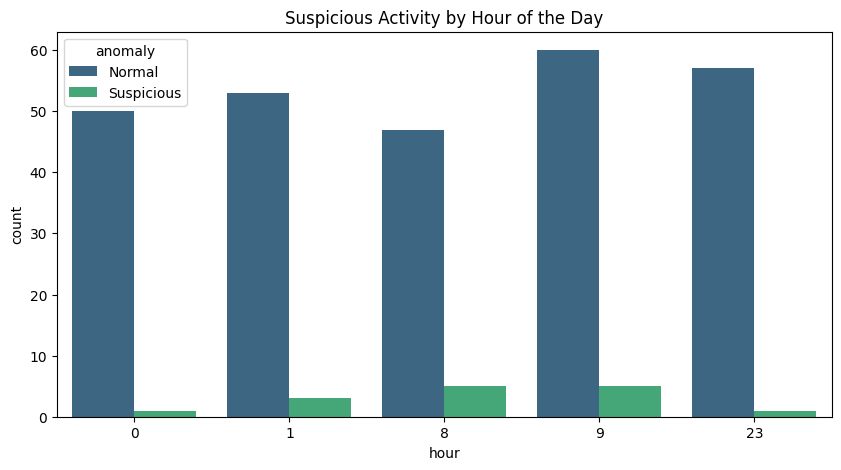

In [ ]:

df['day_of_week'] = df['time'].dt.day_name()
df['hour'] = df['time'].dt.hour


plt.figure(figsize=(10,5))
sns.countplot(x='day_of_week', data=df, hue='anomaly', palette='magma')
plt.title('Attack Frequency by Day of the Week')
plt.show()

plt.figure(figsize=(10,5))
sns.countplot(x='hour', data=df, hue='anomaly', palette='viridis')
plt.title('Suspicious Activity by Hour of the Day')
plt.show()

Top 5 Countries involved in Suspicious Activity:
src_ip_country_code
US    13
NL     2
Name: count, dtype: int64


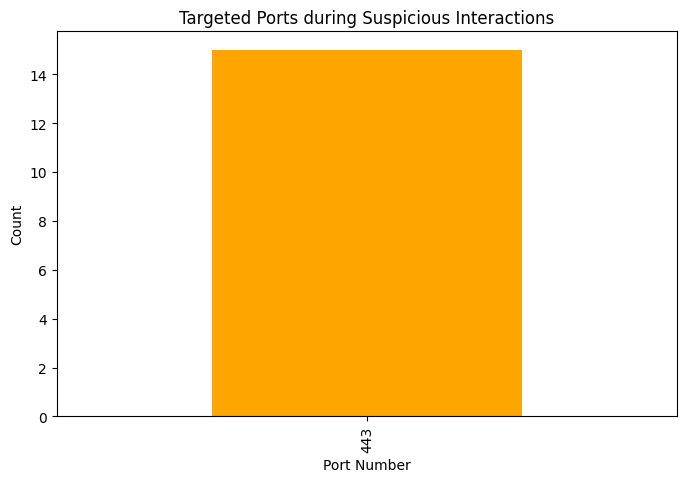

In [ ]:

suspicious_df = df[df['anomaly'] == 'Suspicious']
top_threat_countries = suspicious_df['src_ip_country_code'].value_counts().head(5)

print("Top 5 Countries involved in Suspicious Activity:")
print(top_threat_countries)


plt.figure(figsize=(8,5))
suspicious_df['dst_port'].value_counts().plot(kind='bar', color='orange')
plt.title('Targeted Ports during Suspicious Interactions')
plt.ylabel('Count')
plt.xlabel('Port Number')
plt.show()

In [ ]:
#  Country Count plot
plt.figure(figsize=(15,8))
sns.countplot(y='src_ip_country_code', data=df, order=df['src_ip_country_code'].value_counts().index)
plt.title('Interaction Count by Source IP Country Code')
plt.savefig('country_distribution.png', dpi=300, bbox_inches='tight') # <-- Add this line
plt.show()

#  Traffic Distribution plot
plt.figure(figsize=(12,6))
sns.histplot(df['bytes_in'], bins=50, color='blue', label='Bytes In', kde=True)
sns.histplot(df['bytes_out'], bins=50, color='red', label='Bytes Out', kde=True)
plt.legend()
plt.title('Distribution of Traffic Volume')
plt.savefig('traffic_distribution.png', dpi=300, bbox_inches='tight') # <-- Add this line
plt.show()

#  Anomaly Scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(x='bytes_in', y='bytes_out', hue='anomaly', data=df, palette={'Normal': 'green', 'Suspicious': 'red'})
plt.title('Cybersecurity Anomalies: Bytes In vs Bytes Out')
plt.savefig('anomaly_detection.png', dpi=300, bbox_inches='tight') # <-- Add this line
plt.show()

#  Day/Hour plots
plt.figure(figsize=(10,5))
sns.countplot(x='day_of_week', data=df, hue='anomaly', palette='magma')
plt.title('Attack Frequency by Day of the Week')
plt.savefig('activity_by_day.png', dpi=300, bbox_inches='tight') # <-- Add this line
plt.show()

Objective: Detected suspicious web traffic using AI (Isolation Forest).

Key Finding 1: Found X total anomalies (from your value_counts() earlier).

Key Finding 2: The country [Country Code] showed the highest number of suspicious interactions.

Key Finding 3: Most threats occurred during [Hour] or on [Day], suggesting automated bot activity.

Recommendation: Based on the high bytes_in from src_ip, I recommend blacklisting the top 5 suspicious IP addresses in the WAF (Web Application Firewall).